# **Conditional Variational autoencoder (VAE) - Toy datasets**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import time
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

# **Utility functions**

In [ ]:
def plot_2d_data(data_2d, y, titles=None, figsize = (7, 7)):
  _, axs = plt.subplots(1, len(data_2d), figsize = figsize)

  for i in range(len(data_2d)):
    if (titles != None):
      axs[i].set_title(titles[i])
    scatter=axs[i].scatter(data_2d[i][:, 0], data_2d[i][:, 1],
                            s=1, c=y[i], cmap=plt.cm.Paired)
    axs[i].legend(*scatter.legend_elements())

def plot_history(history,metric=None):
  fig, ax1 = plt.subplots(figsize=(10, 8))

  epoch_count=len(history.history['loss'])

  line1,=ax1.plot(range(1,epoch_count+1),history.history['loss'],
                  label='train_loss',color='orange')
  ax1.plot(range(1,epoch_count+1),history.history['val_loss'],
                  label='val_loss',color = line1.get_color(), linestyle = '--')
  ax1.set_xlim([1,epoch_count])
  ax1.set_ylim([0, max(max(history.history['loss']),
              max(history.history['val_loss']))])
  ax1.set_ylabel('loss',color = line1.get_color())
  ax1.tick_params(axis='y', labelcolor=line1.get_color())
  ax1.set_xlabel('Epochs')
  _=ax1.legend(loc='lower left')

  if (metric!=None):
    ax2 = ax1.twinx()
    line2,=ax2.plot(range(1,epoch_count+1),history.history[metric],
                    label='train_'+metric)
    ax2.plot(range(1,epoch_count+1),history.history['val_'+metric],
                    label='val_'+metric,color = line2.get_color(),
                    linestyle = '--')
    ax2.set_ylim([0, max(max(history.history[metric]),
                max(history.history['val_'+metric]))])
    ax2.set_ylabel(metric,color=line2.get_color())
    ax2.tick_params(axis='y', labelcolor=line2.get_color())
    _=ax2.legend(loc='upper right')

def plot_generated_images(generated_images, nrows, ncols,
                          no_space_between_plots=False, figsize=(10, 10)):
  _, axs = plt.subplots(nrows, ncols,figsize=figsize,squeeze=False)

  for i in range(nrows):
    for j in range(ncols):
      axs[i,j].axis('off')
      axs[i,j].imshow(generated_images[i][j], cmap='gray')

  if no_space_between_plots:
    plt.subplots_adjust(wspace=0,hspace=0)

  plt.show()


In [ ]:
def conditional_input(self, inputs, label_size=10):
    image_size = [self.shape[0], self.shape[1], self.shape[2]]
    input_img = layers.InputLayer(input_shape=image_size,
                                dtype ='float32')(inputs[0])
    input_label = layers.InputLayer(input_shape=(label_size, ),
                                    dtype ='float32')(inputs[1])
    labels = tf.reshape(inputs[1], [-1, 1, 1, label_size])
    labels = tf.cast(labels, dtype='float32')
    ones = tf.ones([inputs[0].shape[0]] + image_size[0:-1] + [label_size])
    labels = ones * labels
    conditional_input = layers.Concatenate(axis=3)([input_img, labels]) 
    return  input_img, input_label, conditional_input

In [ ]:
def sampling(z_mean, z_log_var, input_label):

    eps = tf.random.normal(tf.shape(z_log_var), dtype=tf.float32,
                            mean=0., stddev=1.0, name='epsilon')
    z = z_mean + tf.exp(z_log_var / 2) * eps
    z_cond = tf.concat([z, input_label], axis=1) 
    return z_cond

# **Data import and manipulation**

In [ ]:
category_count=10 

(train_x, train_y), (test_x, test_y) = keras.datasets.cifar10.load_data()

print('Train data flatten shape: ',train_x.shape)
print('Train label shape: ',train_y.shape)
print('Test data flatten shape: ',test_x.shape)
print('Test label shape: ',test_y.shape)

In [ ]:
val_size=10000

train_x, val_x, train_y, val_y = train_test_split(train_x, train_y,
                            test_size = val_size,random_state = 1,shuffle=True)

print('Train data flatten shape: ',train_x.shape)
print('Train label shape: ',train_y.shape)
print('Validation data flatten shape: ',val_x.shape)
print('Validation label shape: ',val_y.shape)

In [ ]:
if len(train_x.shape) == 3:
    train_x = np.expand_dims(train_x, axis=3)
    test_x = np.expand_dims(test_x, axis=3)
    val_x = np.expand_dims(val_x, axis=3)

print('Train shape: ',train_x.shape)
print('Test shape: ',test_x.shape)

In [ ]:
input_shape = train_x.shape[1:]
input_shape

In [ ]:
train_x = train_x/255.0
val_x = val_x/255.0
test_x = test_x/255.0

print('Min value: ',train_x.min())
print('Max value: ',train_x.max())

In [ ]:
if train_x.shape[2] == 1:
    train_x = (train_x * 2) - 1
    val_x = (val_x * 2) - 1
    test_x = (test_x * 2) -1
    print('Min value: ',train_x.min())
    print('Max value: ',train_x.max())

In [ ]:
original_image_shape=(train_x.shape[1], train_x.shape[2])

train_x_flatten=np.reshape(train_x,(train_x.shape[0],-1))
val_x_flatten=np.reshape(val_x,(val_x.shape[0],-1))
test_x_flatten=np.reshape(test_x,(test_x.shape[0],-1))

print('Train data flatten shape: ',train_x_flatten.shape)
print('Validation data flatten shape: ',val_x_flatten.shape)
print('Test data flatten shape: ',test_x_flatten.shape)

In [ ]:
def vae_loss(vae_input, vae_ouput,mu, log_var ,kl_coefficient):
  #Reconstruction loss
  reconstruction_loss = keras.losses.mean_squared_error(vae_input,vae_ouput)* train_x_flatten.shape[1]

  #Regularization loss
  kl_loss = 0.5 * K.sum(K.square(mu) + K.exp(log_var) - log_var - 1, axis = -1)

  #Combined loss
  return reconstruction_loss + kl_coefficient*kl_loss

In [ ]:
train_y_one_hot = to_categorical(train_y,category_count)
val_y_one_hot=to_categorical(val_y,category_count)
test_y_one_hot=to_categorical(test_y,category_count)

print('Train label one hot encoding shape: ',train_y_one_hot.shape)
print('Validation label one hot encoding shape: ',val_y_one_hot.shape)
print('Test label one hot encoding shape: ',test_y_one_hot.shape)

# **CVAE model**
Creating a CVAE class and plugging encoder and decoder

In [ ]:
encoded_dim = 100

In [ ]:
def encoder( input_shape = (28, 28, 1),  label_size=10, encoded_dim = 2): 

    inputs = layers.Input(shape=(input_shape[0],
            input_shape[1], input_shape[2] + label_size), dtype='float32',name='Input')
    #inputs = layers.Input(shape = input_shape)
    #labels_inputs = layers.Input(shape = (50, 50, 2))
    #encoder_inputs = layers.Concatenate()([inputs, labels_inputs])


    #block 1
    x = layers.Conv2D(16, (3, 3),
                      padding='same',
                      name='block1_conv1')(inputs)

    x = layers.Conv2D(16, (3, 3),
                      padding='same',
                      name='block1_conv2')(x)
    x = layers.BatchNormalization()(x)
    # block 2
    x = layers.Conv2D(32, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block2_conv1')(x)
    x = layers.Conv2D(32, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block2_conv2')(x)
    x = layers.MaxPool2D(pool_size=2, strides=2,name='S4')(x)
    
    x = layers.BatchNormalization()(x)
    
    # block 3
    x = layers.Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv1')(x)
    x = layers.Conv2D(64, (3, 3),
                activation='relu',
                padding='same',
                name='block3_conv2')(x)    
                    
    x = layers.Conv2D(filters=5, kernel_size=5,strides=1,padding='same')(x)
    x = layers.Flatten()(x)
    y = layers.Dense(encoded_dim * 2)(x)
    mu = layers.Dense(encoded_dim, name='mu')(y)
    log_var = layers.Dense(encoded_dim, name='log_var')(y)
    

    model = keras.Model(inputs, [mu, log_var], name='encoder')
    
    return model
    

In [ ]:
def decoder(input_shape, encoded_dim = 2,label_size=10): 

    decoder_inputs = layers.Input(shape=(encoded_dim + label_size,) , name='decoder_input')
    x = layers.Dense(encoded_dim)
    x = layers.Dense(encoded_dim * 2)
    #x = layers.Dense(14*14*64)(decoder_inputs)
    x = layers.Dense(input_shape[0]/2 * input_shape[1]/2 *64)(decoder_inputs)
    x = layers.Reshape(target_shape=(int(input_shape[0]/2),
                     int(input_shape[1]/2), 64))(x)
    x = layers.Conv2DTranspose(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='up_block4_conv1')(x)
    x = layers.Conv2DTranspose(64, (3, 3),
                    activation='relu',
                    padding='same',
                    name='up_block4_conv2')(x)  
    
    # block 2
    x = layers.Conv2DTranspose(32, (3, 3),
                      activation='relu',
                      padding='same',
                      name='up_block5_conv1')(x)
    x = layers.Conv2DTranspose(32, (3, 3),
                      activation='relu',
                      padding='same',
                      name='up_block5_conv2')(x)
    x = layers.UpSampling2D()(x)
    
    # block 3
    x = layers.Conv2DTranspose(16, (3, 3),
                      activation='relu',
                      padding='same',
                      name='up_block6_conv1')(x)

    x = layers.Conv2DTranspose(16, (3, 3),
                    activation='relu',
                    padding='same',
                    name='up_block6_conv2')(x)
                                   
    outputs = layers.Conv2DTranspose(filters=input_shape[-1], kernel_size=2, strides=1, activation='sigmoid',padding='same')(x)

    model = keras.Model(decoder_inputs, outputs, name='decoder')
    return model

In [ ]:
cvae_encoder = encoder(encoded_dim = encoded_dim, input_shape = input_shape)
cvae_decoder = decoder(encoded_dim = encoded_dim, input_shape = input_shape)


In [ ]:
cvae_encoder.summary()

In [ ]:
class CVAE(keras.Model):
    def __init__(self, encoder, decoder, beta, shape, **kwargs):
        super(CVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta
        self.shape = shape
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        #
        self.v_total_loss_tracker = keras.metrics.Mean(name="v_total_loss")
        self.v_reconstruction_loss_tracker = keras.metrics.Mean(
            name="v_reconstruction_loss")
        self.v_kl_loss_tracker = keras.metrics.Mean(name="v_kl_loss")
    
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
       
    def call(self, inputs):
        _, input_label, conditional_input = self.conditional_input(inputs)
        z_mean, z_log_var = self.encoder(conditional_input)
        z_cond = self.sampling(z_mean, z_log_var, input_label)
        return self.decoder(z_cond)
    
    def conditional_input(self, inputs, label_size=10): 
        image_size = [self.shape[0], self.shape[1], self.shape[2]]
        input_img = layers.InputLayer(input_shape=image_size,
                                      dtype ='float32')(inputs[0])
        input_label = layers.InputLayer(input_shape=(label_size, ),
                                        dtype ='float32')(inputs[1])
        labels = tf.reshape(inputs[1], [-1, 1, 1, label_size])
        labels = tf.cast(labels, dtype='float32')
        ones = tf.ones([inputs[0].shape[0]] + image_size[0:-1] + [label_size]) 
        labels = ones * labels
        conditional_input = layers.Concatenate(axis=3)([input_img, labels]) 
        return  input_img, input_label, conditional_input

    def sampling(z_mean, z_log_var, input_label):

        eps = tf.random.normal(tf.shape(z_log_var), dtype=tf.float32,
                               mean=0., stddev=1.0, name='epsilon')
        z = z_mean + tf.exp(z_log_var / 2) * eps
        z_cond = tf.concat([z, input_label], axis=1)
        return z_cond

    def train_step(self, data):

        if isinstance(data, tuple):
            data = data[0]
    
        with tf.GradientTape() as tape:
        
            input_img, input_label, conditional_input = self.conditional_input(data)
            z_mean, z_log_var = self.encoder(conditional_input)
            z_cond = self.sampling(z_mean, z_log_var, input_label)
            reconstruction = self.decoder(z_cond)
            reconstruction_loss = np.prod(self.shape) * tf.keras.losses.MSE(tf.keras.backend.flatten(input_img),
                                    tf.keras.backend.flatten(reconstruction))     
            
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean)
                      - tf.exp(z_log_var))
            kl_loss = tf.reduce_sum(kl_loss, axis=1)
            total_loss = reconstruction_loss + (self.beta * kl_loss)
            total_loss = tf.reduce_mean(total_loss) 
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        input_img, input_label, conditional_input = self.conditional_input(data)
        z_mean, z_log_var = self.encoder(conditional_input)
        z_cond = self.sampling(z_mean, z_log_var, input_label)
        reconstruction = self.decoder(z_cond)
        reconstruction_loss = np.prod(self.shape) * tf.keras.losses.MSE(tf.keras.backend.flatten(input_img), tf.keras.backend.flatten(reconstruction)) # over weighted MSE    

        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean)
                  - tf.exp(z_log_var))
        kl_loss = tf.reduce_sum(kl_loss, axis=1)
        total_loss = reconstruction_loss + (self.beta * kl_loss)
        total_loss = tf.reduce_mean(total_loss)
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return{
            'loss': total_loss,
            'reconstruction_loss': reconstruction_loss,
            'kl_loss': kl_loss
        }


In [ ]:
kl_coefficient=1
cvae = CVAE(cvae_encoder, cvae_decoder, kl_coefficient, input_shape)
cvae.built = True
cvae.summary()

In [ ]:
cvae_input = cvae.encoder.input[0]
cvae_output = cvae.decoder.output
mu = cvae.encoder.get_layer('mu').output
log_var = cvae.encoder.get_layer('log_var').output

cvae.compile(optimizer='adam')

## **Training**

In [ ]:
epoch_count = 100
batch_size = 100
patience = 5

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',
             patience=patience, restore_best_weights=True)

history = cvae.fit([train_x,train_y_one_hot],
                   validation_data=([val_x,val_y_one_hot],None),
                   epochs=epoch_count,
                   batch_size=batch_size,
                   callbacks=[early_stop])

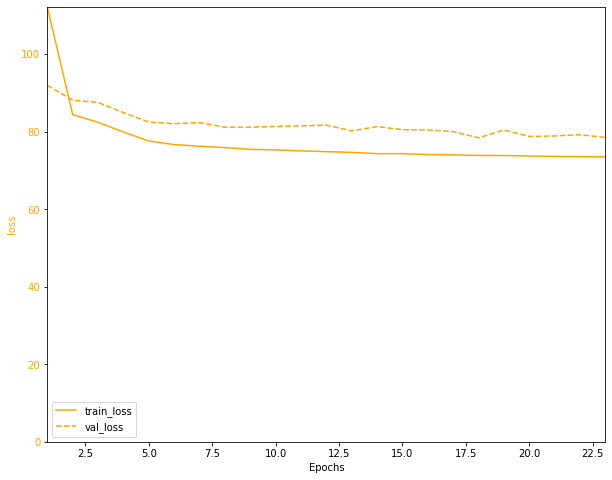

In [415]:
plot_history(history)

In [ ]:
test_loss = cvae.evaluate([test_x, test_y_one_hot],None,
            batch_size=batch_size,verbose=0)
print('Test loss: {:.3f}'.format(test_loss[0]))

## **Embdedding**

In [ ]:

label_size = 10
_, input_label_train, train_input = cvae.conditional_input([train_x, train_y_one_hot])
_, input_label_test, test_input = cvae.conditional_input([test_x, test_y_one_hot])
_, input_label_val, val_input = cvae.conditional_input([val_x, val_y_one_hot])


print(input_label_train.shape)
print(train_input.shape)

In [ ]:
train_x_mean, train_log_var = cvae.encoder.predict(train_input)
test_x_mean, test_log_var = cvae.encoder.predict(test_input)
val_x_mean, val_log_var = cvae.encoder.predict(val_input)

print(train_x_mean.shape)
print(train_log_var.shape)

In [ ]:
from sklearn import manifold
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
train_x_tsne = tsne.fit_transform(train_x_mean[:1000])
test_x_tsne = tsne.fit_transform(test_x_mean[:1000])
val_x_tsne = tsne.fit_transform(val_x_mean[:1000])

In [ ]:
plot_2d_data( [train_x_tsne, test_x_tsne, val_x_tsne],
            [train_y[:1000], test_y[:1000] ,val_y[:1000]],
            ['Train','Test', 'Validation'],(18,6))

## **Reconstruction**

In [ ]:
#reconstructions...
z_cond_train = sampling(train_x_mean, train_log_var, input_label_train)
z_cond_test = sampling(test_x_mean, test_log_var, input_label_test)
z_cond_val = sampling(val_x_mean, val_log_var, input_label_val)

In [ ]:
reconstruction_train = cvae.decoder(z_cond_train)
reconstruction_test = cvae.decoder(z_cond_test)
reconstruction_val = cvae.decoder(z_cond_val)

In [ ]:
image_count = 5

_, axs = plt.subplots(2, image_count, figsize=(15, 5))
for i in range(image_count):
  random_idx = random.randint(0, train_x.shape[0])
  axs[0, i].imshow(train_x[random_idx])
  axs[0, i].axis('off')
  axs[0, i].set_title(train_y[random_idx])
  axs[1, i].imshow(reconstruction_train[random_idx])
  axs[1, i].axis('off')



## **Generation**

In [ ]:
def reparametrization(z_mean, z_log_var, input_label):
    """ Performs the riparametrization trick"""

    eps = tf.random.normal(shape = (input_label.shape[0], encoded_dim), mean = 0.0, stddev = 1.0)       
    z = z_mean + tf.math.exp(z_log_var * .5) * eps
    z_cond = tf.concat([z, input_label], axis=1) # (batch_size, label_dim + latent_dim)

    return z_cond

In [ ]:
digit_label = 5
digit_label_one_hot = to_categorical(digit_label, category_count).reshape(1,-1)
a = tf.convert_to_tensor(digit_label_one_hot)
b = tf.concat([a, a], axis=0) # with 1 dimension, it fails...
b.shape

In [ ]:
digit_label_one_hot = train_y_one_hot[:batch_size]
inputs = [train_x[:2], digit_label_one_hot] #train_x a placeholder for dims
_, labels,_ = cvae.conditional_input(inputs)
z_cond = reparametrization(z_mean=0., z_log_var=.3, input_label = b)
decoded_x = cvae_decoder.predict(z_cond)
digit = decoded_x[1].reshape(input_shape) 
plt.axis('off')
plt.imshow(digit)
plt.show()

In [ ]:
n = 10  # number of images per row and column
limit=3 # random values are sampled from the range [-limit,+limit]
first_dim_const= 0  # constant value of the second latent dimension

grid_y = np.linspace(-limit,limit, n) 

generated_images=[]
for digit_label in range(category_count):
  digit_label_one_hot=to_categorical(digit_label, category_count).reshape(1,-1)
  
  single_row_generated_images=[]
  for i, yi in enumerate(grid_y):
    random_sample = np.array([[first_dim_const, yi]])
    z_cond = sampling(z_mean=random_sample, z_log_var=0.3, input_label = digit_label_one_hot )
    decoded_x = cvae_decoder.predict(z_cond)
    single_row_generated_images.append(decoded_x[0].reshape(input_shape))
  generated_images.append(single_row_generated_images)      

plot_generated_images(generated_images,n,n)